<a href="https://colab.research.google.com/github/asepdeffyc/bigdata/blob/main/MovieLens_Data_Analysis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MovieLens Data Analysis 
### for Recommendation using K-Means Clustering Method

---
**Asep Deffy Ciftady**

2301201018

---

# Setting up PySpark in Colab

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget -q https://www-us.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz

In [3]:
!tar xf spark-3.1.1-bin-hadoop2.7.tgz

In [4]:
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()

In [7]:
findspark.find()

'/content/spark-3.1.1-bin-hadoop2.7'

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [9]:
spark

In [10]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2021-06-16 21:12:28--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.170.116.11, 3.224.116.172, 34.226.165.133, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.170.116.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  47.6MB/s    in 0.3s    

2021-06-16 21:12:28 (47.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [12]:
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[{"name":"command_line","uri":"/api/tunnels/command_line","public_url":"https://2e896bb44ff2.ngrok.io","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}},{"name":"command_line (http)","uri":"/api/tunnels/command_line%20%28http%29","public_url":"http://2e896bb44ff2.ngrok.io","proto":"http","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}}],"uri":"/api/tunnels"}


# Exploratory Data Analysis (EDA)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!unzip "/content/drive/My Drive/ml-latest-small.zip"

Archive:  /content/drive/My Drive/ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
!cat "/content/ml-latest-small/README.txt"

Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for down

In [ ]:
!head -5 "/content/ml-latest-small/ratings.csv"

userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815


In [ ]:
!head -5 "/content/ml-latest-small/tags.csv"

userId,movieId,tag,timestamp
2,60756,funny,1445714994
2,60756,Highly quotable,1445714996
2,60756,will ferrell,1445714992
2,89774,Boxing story,1445715207


In [17]:
!head -5 "/content/ml-latest-small/movies.csv"

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance


In [ ]:
import pandas as pd

Movies

In [19]:
df = spark.read.csv('ml-latest-small/movies.csv', header=True, inferSchema=True)
df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [23]:
movies = df.toPandas()

In [24]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int32 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int32(1), object(2)
memory usage: 190.4+ KB


Ratings

In [25]:
df = spark.read.csv('ml-latest-small/ratings.csv', header=True, inferSchema=True)
df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [27]:
ratings = df.toPandas()

In [28]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int32  
 1   movieId    100836 non-null  int32  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int32  
dtypes: float64(1), int32(3)
memory usage: 1.9 MB


In [29]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


# Brainstorming Insight 1
*   Bagaimana agar pelanggan betah menonton film di layanan streaming berbayar sehingga tidak mudah berpindah ke layanan streaming lainnya dan menjadi pelanggan setia
*   Pelanggan yang setia akan melakukan pembayaran rutin sehingga mendukung untuk keuntungan sisi finansial perusahaan
*   Dengan memberikan rekomendasi film-film yang sesuai
*   Tahap ini akan mencoba meng-clustering kan user-user yang memiliki kemiripan rating dalam suatu genre



## Data Preparation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

In [ ]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
    
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In [ ]:
genre_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 610 entries, 1 to 610
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   avg_romance_rating  606 non-null    float64
 1   avg_scifi_rating    605 non-null    float64
dtypes: float64(2)
memory usage: 14.3+ KB


In [ ]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


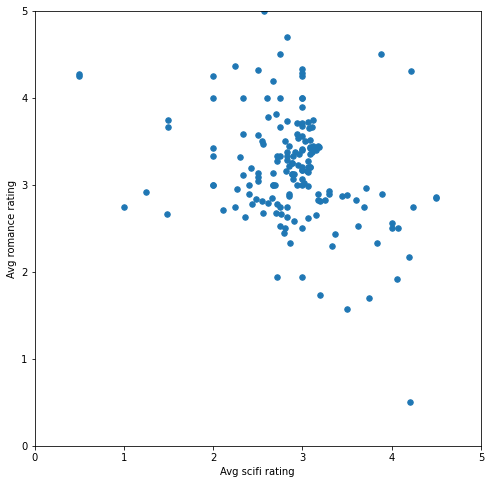

In [ ]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
    
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

## K-Means Clustering

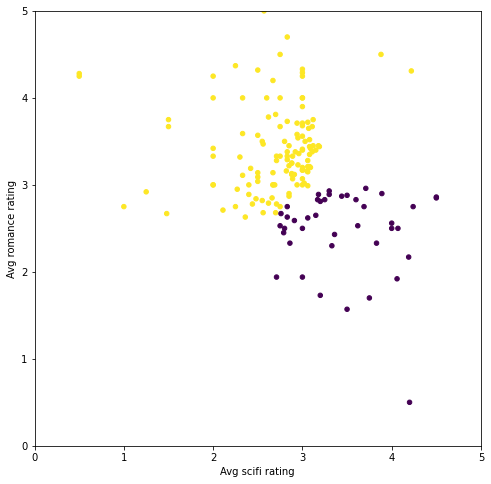

In [ ]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')

    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

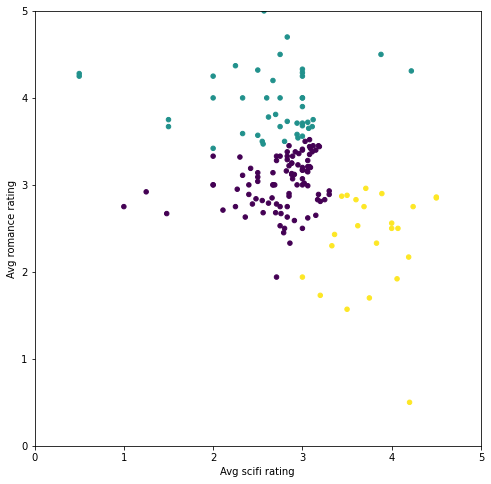

In [ ]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

## Silhouette Evaluation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.


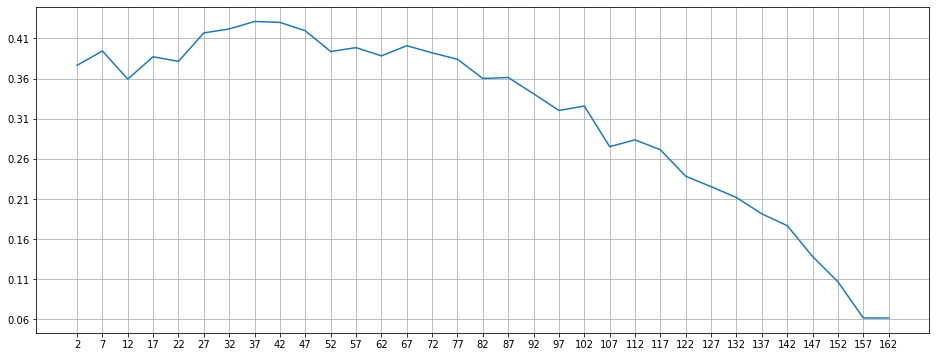

In [ ]:
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

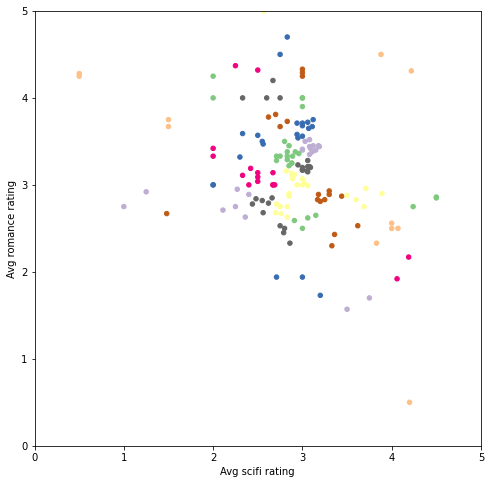

In [ ]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=37)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

## Adding Feature

In [ ]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],                                          
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])

# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


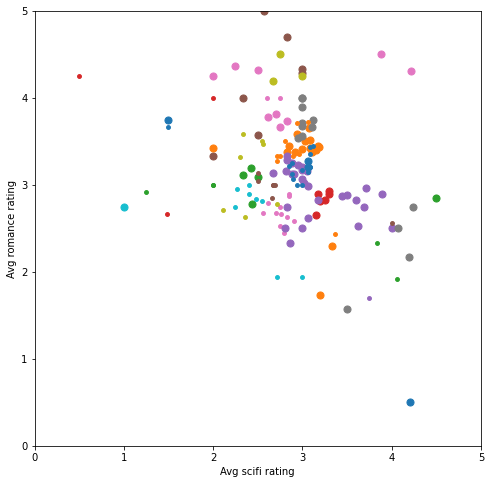

In [ ]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values

# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=37)

# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)

# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')

    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3: 
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'], 
                        point['avg_romance_rating'], 
                        s=size, 
                        color=color)
            
# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

## Insight


*   Dari algoritma K-means dengan menggunakan evaluasi Silhoute untuk mendapatkan cluster berkualitas dan menghindari salah kesimpulan di dapatkan K terbaik sejumlah 37, kedekatan similarity berdasarkan rata-rata rating dalam genre sci-fi, romance dengan kluster terbaik terbagi kedalam 37 kelompok kecil
*   Dengan penambahan fitur genre lainnya yaitu rata-rata rating di genre action yang ditandai dengan plot yang lebih tebal dan berkelompok kecil akan meningkatkan similarity user dalam kelompok tertentu berdasarkan rating film di genre yang dimasukan
*   Pengelompokan berdasarkan rating berdasarkan genre ini bisa dijadikan dasar untuk user lain mendapatkan film dgn genre yg sama yg serupa untuk di rekomendasikan
*   Tapi hanya sampai rekomendasi genre yg mirip dengan user lain, belum sampai ke film didalamnya



# Brainstorming Insight 2
*   Bagaimana agar pelanggan betah menonton film di layanan streaming berbayar sehingga tidak mudah berpindah ke layanan streaming lainnya dan menjadi pelanggan setia
*   Pelanggan yang setia akan melakukan pembayaran rutin sehingga mendukung untuk keuntungan sisi finansial perusahaan
*   Dengan memberikan rekomendasi film-film yang sesuai
*   Tahap ini akan mencoba meng-clustering kan user-user yang memiliki kemiripan rating dalam setiap film

## Data Preparation

In [ ]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :50]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),127 Hours (2010),13 Assassins (Jûsan-nin no shikaku) (2010),13 Ghosts (1960),13 Going on 30 (2004),13 Hours (2016),13 Sins (2014),13 Tzameti (2005),13th (2016),"13th Warrior, The (1999)",1408 (2007)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head(18)

dataset dimensions:  (18, 30)


title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),"Usual Suspects, The (1995)",American Beauty (1999),Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)"
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,3.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0,3.5,4.0,5.0,4.5,3.0,3.0,4.0,4.5,5.0,4.5,4.5,5.0,4.0,3.5,4.0,5.0,4.5,4.0,4.0,3.5
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,4.0,4.0,5.0,4.0,3.5,4.0,4.0,4.5,4.0,5.0,4.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,4.0,5.0
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,4.5,3.0,5.0,3.5,4.0,4.5,3.0,3.5,5.0,3.5,3.5,5.0,3.5,4.5,4.5,4.5,4.0,4.0,4.0,4.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,2.5,2.5,5.0,3.0,5.0,4.0,4.0,3.0,5.0,4.5,5.0,4.0,4.5,4.0,4.0,4.0,4.5,3.5,2.5,2.5
482,5.0,5.0,5.0,NaN,4.5,4.5,4.0,4.0,4.0,5.0,4.5,4.0,4.5,4.5,4.0,3.5,3.0,2.0,4.0,4.5,4.5,4.0,2.5,3.5,4.0,4.5,4.0,4.0,4.0,3.5
248,4.5,4.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.5,5.0,4.0,5.0,4.0,4.5,5.0,4.0,2.5,5.0,5.0,4.5,4.5,4.5,NaN,4.5,4.5,5.0,4.0,4.5,4.0
579,4.0,5.0,5.0,4.5,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,5.0,5.0,5.0,3.0,NaN,4.5,4.5,4.0,4.5,3.0,3.0,5.0,4.5,4.0,2.0,4.0,4.5
273,4.5,4.5,5.0,4.0,4.0,3.0,3.5,4.5,4.5,4.0,5.0,4.0,4.5,4.0,5.0,4.0,3.5,NaN,4.0,3.0,4.0,3.5,3.5,3.0,4.0,3.5,3.0,4.0,3.0,4.0
306,4.0,4.5,4.5,4.5,3.5,3.5,3.5,3.5,2.5,4.5,4.0,4.0,3.0,4.5,4.0,4.0,2.0,2.0,4.0,3.0,3.0,4.5,3.0,4.0,NaN,3.0,3.0,4.0,3.0,2.5


## K-Means Clustering

In [ ]:
# Pivot the dataset and choose the first 500 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 500).fillna(0)
most_rated_movies_1k.head()

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),"Usual Suspects, The (1995)",American Beauty (1999),Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),Mission: Impossible (1996),...,The Martian (2015),Princess Mononoke (Mononoke-hime) (1997),Big Daddy (1999),Dark City (1998),Seven Samurai (Shichinin no samurai) (1954),Nine Months (1995),Garden State (2004),Highlander (1986),Wallace & Gromit: A Close Shave (1995),Hotel Rwanda (2004),Jackie Brown (1997),"Thomas Crown Affair, The (1999)",Troy (2004),Ghostbusters II (1989),Sling Blade (1996),Pi (1998),Singin' in the Rain (1952),"Ring, The (2002)",Poltergeist (1982),Chocolat (2000),"Terminal, The (2004)",Harry Potter and the Deathly Hallows: Part 1 (2010),Analyze This (1999),Mad Max: Fury Road (2015),"Hunchback of Notre Dame, The (1996)",Basic Instinct (1992),101 Dalmatians (1996),Alien³ (a.k.a. Alien 3) (1992),Lethal Weapon 2 (1989),50 First Dates (2004),Iron Man 2 (2010),Beverly Hills Cop (1984),"Pursuit of Happyness, The (2006)",The Butterfly Effect (2004),Sneakers (1992),"Me, Myself & Irene (2000)",Fear and Loathing in Las Vegas (1998),Gran Torino (2008),"Simpsons Movie, The (2007)",Phenomenon (1996)
0,4.0,0.0,3.0,4.0,5.0,5.0,4.0,4.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,0.0,5.0,0.0,5.0,0.0,5.0,4.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,3.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,5.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,5.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,5.0,0.0,0.0,0.0,0.0,4.0,3.0,5.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,3.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Conversion to sparse csr matrix
sp_arr = csr_matrix(most_rated_movies_1k)
sdf = pd.DataFrame.sparse.from_spmatrix(sp_arr)
sparse_ratings = sdf.sparse.to_coo()
print(sparse_ratings)

  (0, 0)	4.0
  (5, 0)	5.0
  (6, 0)	5.0
  (7, 0)	3.0
  (9, 0)	3.5
  (10, 0)	5.0
  (13, 0)	4.0
  (14, 0)	5.0
  (15, 0)	3.5
  (16, 0)	5.0
  (17, 0)	4.5
  (18, 0)	2.0
  (20, 0)	4.5
  (21, 0)	5.0
  (23, 0)	4.5
  (25, 0)	3.0
  (26, 0)	5.0
  (27, 0)	4.0
  (28, 0)	4.5
  (32, 0)	5.0
  (33, 0)	4.0
  (36, 0)	4.0
  (37, 0)	3.0
  (40, 0)	2.0
  (41, 0)	5.0
  :	:
  (329, 499)	2.5
  (334, 499)	3.0
  (336, 499)	5.0
  (349, 499)	3.0
  (355, 499)	2.0
  (388, 499)	4.0
  (413, 499)	3.0
  (427, 499)	3.0
  (430, 499)	1.5
  (436, 499)	3.0
  (437, 499)	3.5
  (447, 499)	3.0
  (450, 499)	3.0
  (455, 499)	4.0
  (473, 499)	2.0
  (476, 499)	3.5
  (479, 499)	3.0
  (482, 499)	2.5
  (488, 499)	1.0
  (491, 499)	4.0
  (520, 499)	4.0
  (571, 499)	3.0
  (595, 499)	3.5
  (598, 499)	2.5
  (607, 499)	3.0


In [ ]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
# Select the mas number of users and movies heatmap cluster
max_users = 70
max_movies = 50
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
clustered.head()
#draw_movie_clusters(clustered, max_users, max_movies)

,index,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),"Usual Suspects, The (1995)",American Beauty (1999),Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),...,Princess Mononoke (Mononoke-hime) (1997),Big Daddy (1999),Dark City (1998),Seven Samurai (Shichinin no samurai) (1954),Nine Months (1995),Garden State (2004),Highlander (1986),Wallace & Gromit: A Close Shave (1995),Hotel Rwanda (2004),Jackie Brown (1997),"Thomas Crown Affair, The (1999)",Troy (2004),Ghostbusters II (1989),Sling Blade (1996),Pi (1998),Singin' in the Rain (1952),"Ring, The (2002)",Poltergeist (1982),Chocolat (2000),"Terminal, The (2004)",Harry Potter and the Deathly Hallows: Part 1 (2010),Analyze This (1999),Mad Max: Fury Road (2015),"Hunchback of Notre Dame, The (1996)",Basic Instinct (1992),101 Dalmatians (1996),Alien³ (a.k.a. Alien 3) (1992),Lethal Weapon 2 (1989),50 First Dates (2004),Iron Man 2 (2010),Beverly Hills Cop (1984),"Pursuit of Happyness, The (2006)",The Butterfly Effect (2004),Sneakers (1992),"Me, Myself & Irene (2000)",Fear and Loathing in Las Vegas (1998),Gran Torino (2008),"Simpsons Movie, The (2007)",Phenomenon (1996),group
0,0,4.0,0.0,3.0,4.0,5.0,5.0,4.0,4.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,0.0,5.0,0.0,5.0,0.0,5.0,4.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,12
1,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
3,3,0.0,0.0,1.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,5.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,5.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4,4,0.0,3.0,5.0,0.0,0.0,0.0,0.0,4.0,3.0,5.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,3.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18


In [ ]:
# Pick a cluster ID from the clusters above
cluster_number = 17
# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
#cluster.head()
#draw_movies_heatmap(cluster, axis_labels=False)

In [ ]:
# Print the ratings
cluster.fillna('')

,Forrest Gump (1994),Close Encounters of the Third Kind (1977),Con Air (1997),Chinatown (1974),My Cousin Vinny (1992),Beverly Hills Cop III (1994),Star Trek (2009),Mr. & Mrs. Smith (2005),American Psycho (2000),Spaceballs (1987),Hot Shots! Part Deux (1993),Batman Returns (1992),"Mask of Zorro, The (1998)",My Big Fat Greek Wedding (2002),Vertigo (1958),Pinocchio (1940),Judge Dredd (1995),Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002),Superman (1978),Hot Fuzz (2007),Charlie and the Chocolate Factory (2005),Predator (1987),Gone in 60 Seconds (2000),Pleasantville (1998),"I, Robot (2004)","Three Musketeers, The (1993)",Wayne's World (1992),"Piano, The (1993)",Animal House (1978),Star Trek II: The Wrath of Khan (1982),Love Actually (2003),Guardians of the Galaxy (2014),Brazil (1985),Grosse Pointe Blank (1997),"Full Monty, The (1997)",Crocodile Dundee (1986),12 Angry Men (1957),"Goonies, The (1985)","Social Network, The (2010)",Anchorman: The Legend of Ron Burgundy (2004),...,"Rock, The (1996)",E.T. the Extra-Terrestrial (1982),Spider-Man (2002),"Beautiful Mind, A (2001)",Twister (1996),Blade Runner (1982),"Incredibles, The (2004)",Four Weddings and a Funeral (1994),Aliens (1986),Goodfellas (1990),Babe (1995),"Godfather: Part II, The (1974)",American History X (1998),Eternal Sunshine of the Spotless Mind (2004),Kill Bill: Vol. 1 (2003),"Terminator, The (1984)",Reservoir Dogs (1992),"Monsters, Inc. (2001)",GoldenEye (1995),X-Men (2000),One Flew Over the Cuckoo's Nest (1975),"Fifth Element, The (1997)",Batman Begins (2005),Home Alone (1990),Ghost (1990),Clerks (1994),WALL·E (2008),Taxi Driver (1976),There's Something About Mary (1998),Up (2009),"Big Lebowski, The (1998)",Sleepless in Seattle (1993),Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),"Departed, The (2006)",Apocalypse Now (1979),Star Trek: Generations (1994),Indiana Jones and the Temple of Doom (1984),"Shining, The (1980)",Donnie Darko (2001),Interview with the Vampire: The Vampire Chronicles (1994)
0,4.5,0.0,0.0,4.0,0.0,0.0,3.5,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,4.0,0.0,0.0,0.0,3.5,0.0,3.0,0.0,0.0,4.5,0.0,4.5,0.0,0.0,0.0,3.0,5.0,0.0,0.0,2.5,...,0.0,0.0,4.0,4.5,0.0,4.0,3.5,0.0,0.0,4.5,2.5,5.0,4.0,4.0,3.5,4.0,4.0,4.0,0.0,4.0,4.5,3.5,4.5,3.5,0.0,4.0,0.0,4.0,0.0,4.0,4.5,0.0,3.5,4.5,3.5,4.0,4.0,0.0,0.0,0.0
1,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,3.5,4.0,0.0,3.5,0.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,4.5,0.0,4.0,3.0,...,0.0,0.0,3.5,4.0,0.0,4.0,3.5,0.0,0.0,5.0,0.0,4.5,4.0,5.0,4.0,0.0,5.0,3.5,0.0,3.5,4.5,0.0,4.0,0.0,0.0,0.0,5.0,4.5,0.0,3.5,0.0,0.0,3.5,5.0,5.0,0.0,0.0,4.0,5.0,0.0
2,4.5,0.0,1.5,4.0,5.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,5.0,4.0,3.5,0.0,0.0,3.0,0.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,4.0,4.5,4.0,0.0,0.0,0.0,5.0,0.0,5.0,3.0,...,4.0,0.0,0.0,5.0,0.0,4.0,3.0,5.0,3.5,5.0,3.0,5.0,5.0,0.0,5.0,3.5,5.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,4.0,5.0,0.0,0.0,5.0,4.5,0.0,3.0,4.5,0.0,0.0,1.0,5.0,5.0,0.0
3,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,3.5,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,...,0.0,3.0,3.5,3.5,3.5,5.0,4.5,0.0,4.5,4.0,2.5,4.0,4.0,4.0,5.0,3.5,5.0,0.0,3.5,4.5,4.0,4.5,5.0,0.0,1.5,3.5,0.0,4.0,4.0,0.0,4.5,0.0,0.0,4.5,3.5,4.0,3.5,0.0,4.0,0.0


In [ ]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Forrest Gump (1994)"
cluster[movie_name].mean()

4.125

In [ ]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(10)

Forrest Gump (1994)                          4.125
Close Encounters of the Third Kind (1977)    1.000
Con Air (1997)                               0.375
Chinatown (1974)                             2.000
My Cousin Vinny (1992)                       1.250
Beverly Hills Cop III (1994)                 0.000
Star Trek (2009)                             1.875
Mr. & Mrs. Smith (2005)                      0.000
American Psycho (2000)                       2.875
Spaceballs (1987)                            0.875
dtype: float64

In [ ]:
# Pick a user ID from the dataset
user_id = 2

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
print(user_2_ratings)
print("======")
# Which movies did they not rate? 
user_2_unrated_movies =  user_2_ratings[user_2_ratings==0.0]
print(user_2_unrated_movies)
print("======")
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
print(avg_ratings)
print("======")
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]
#print(avg_ratings)

Forrest Gump (1994)                                          4.5
Close Encounters of the Third Kind (1977)                    0.0
Con Air (1997)                                               1.5
Chinatown (1974)                                             4.0
My Cousin Vinny (1992)                                       5.0
                                                            ... 
Star Trek: Generations (1994)                                0.0
Indiana Jones and the Temple of Doom (1984)                  1.0
Shining, The (1980)                                          5.0
Donnie Darko (2001)                                          5.0
Interview with the Vampire: The Vampire Chronicles (1994)    0.0
Name: 2, Length: 300, dtype: float64
Close Encounters of the Third Kind (1977)                    0.0
Beverly Hills Cop III (1994)                                 0.0
Mr. & Mrs. Smith (2005)                                      0.0
Hot Shots! Part Deux (1993)                          

Eternal Sunshine of the Spotless Mind (2004)       3.250
X-Men: The Last Stand (2006)                       3.125
Taxi Driver (1976)                                 3.125
Ring, The (2002)                                   3.125
Sleepy Hollow (1999)                               3.000
Apocalypse Now (1979)                              3.000
X-Men (2000)                                       3.000
The Butterfly Effect (2004)                        3.000
Charlie and the Chocolate Factory (2005)           2.750
Spider-Man (2002)                                  2.750
Austin Powers in Goldmember (2002)                 2.625
School of Rock (2003)                              2.500
Citizen Kane (1941)                                2.250
Star Trek II: The Wrath of Khan (1982)             2.125
Seven Samurai (Shichinin no samurai) (1954)        2.125
Fifth Element, The (1997)                          2.000
Scary Movie (2000)                                 2.000
Wallace & Gromit: A Close Shave